In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [10]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.4772 - acc: 0.2365
Epoch 00001: val_loss improved from inf to 2.25122, saving model to model/checkpoint/1D_CNN_custom_DO_BN_1_conv_checkpoint/001-2.2512.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 3.4771 - acc: 0.2365 - val_loss: 2.2512 - val_acc: 0.2970
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5221 - acc: 0.5434
Epoch 00002: val_loss did not improve from 2.25122
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.5220 - acc: 0.5434 - val_loss: 2.4866 - val_acc: 0.2954
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0844 - acc: 0.9830
Epoch 00027: val_loss did not improve from 2.25122
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0844 - acc: 0.9830 - val_loss: 6.3833 - val_acc: 0.2888
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0904 - acc: 0.9811
Epoch 00028: val_loss did not improve from 2.25122
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0904 - acc: 0.9811 - val_loss: 6.0583 - val_acc: 0.2914
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0885 - acc: 0.9817
Epoch 00029: val_loss did not improve from 2.25122
36805/36805 [==============================] - 43s 1ms/sample - loss: 0.0885 - acc: 0.9817 - val_loss: 6.4023 - val_acc: 0.2807
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0842 - acc: 0.9829
Epoch 00030: val_loss did not improve from 2.25122
36805/36805 [===========

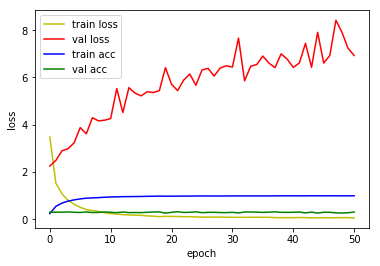

4815/4815 [==============================] - 2s 400us/sample - loss: 2.3054 - acc: 0.2748
Loss: 2.3053826310305334 Accuracy: 0.27476636

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0391 - acc: 0.2667
Epoch 00001: val_loss improved from inf to 3.23351, saving model to model/checkpoint/1D_CNN_custom_DO_BN_2_conv_checkpoint/001-3.2335.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 3.0392 - acc: 0.2667 - val_loss: 3.2335 - val_acc: 0.1917
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9317 - acc: 0.4469
Epoch 00002: val_loss improved from 3.23351 to 2.73035, saving model to model/checkpoint/1D_CNN_custom_DO_BN_2_conv_checkpoint/002-2.7304.hdf5
36805/36805 [==============================] - 72s 2ms/sample - loss: 1.9316 - acc: 0.4469 - val_loss: 2.7304 - val_acc: 0.3063
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5411 - 

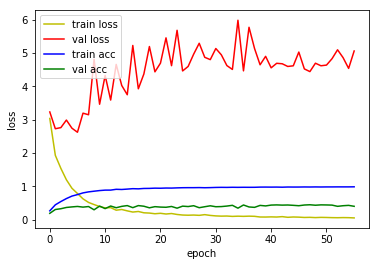

4815/4815 [==============================] - 3s 670us/sample - loss: 2.7925 - acc: 0.3780
Loss: 2.7925413291154744 Accuracy: 0.37798545

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3626 - acc: 0.3399
Epoch 00001: val_loss improved from inf to 2.18262, saving model to model/checkpoint/1D_CNN_custom_DO_BN_3_conv_checkpoint/001-2.1826.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 2.3625 - acc: 0.3399 - val_loss: 2.1826 - val_acc: 0.3333
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5660 - acc: 0.5230
Epoch 00002: val_loss improved from 2.18262 to 1.49349, saving model to model/checkpoint/1D_CNN_custom_DO_BN_3_conv_checkpoint/002-1.4935.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.5660 - acc: 0.5229 - val_loss: 1.4935 - val_acc: 0.5271
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2747 - 

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1355 - acc: 0.9593
Epoch 00030: val_loss did not improve from 1.49349
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.1355 - acc: 0.9593 - val_loss: 2.4701 - val_acc: 0.5604
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1265 - acc: 0.9604
Epoch 00031: val_loss did not improve from 1.49349
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.1265 - acc: 0.9604 - val_loss: 2.2247 - val_acc: 0.6094
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1181 - acc: 0.9634
Epoch 00032: val_loss did not improve from 1.49349
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.1181 - acc: 0.9634 - val_loss: 2.3409 - val_acc: 0.6075
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1253 - acc: 0.9615
Epoch 00033: val_loss did not improve from 1.49349
36805/36805 [===========

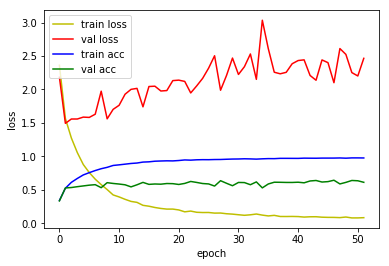

4815/4815 [==============================] - 4s 786us/sample - loss: 1.5907 - acc: 0.5034
Loss: 1.590732184525962 Accuracy: 0.5034268

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2488 - acc: 0.3430
Epoch 00001: val_loss improved from inf to 1.63984, saving model to model/checkpoint/1D_CNN_custom_DO_BN_4_conv_checkpoint/001-1.6398.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 2.2490 - acc: 0.3430 - val_loss: 1.6398 - val_acc: 0.4680
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4705 - acc: 0.5458
Epoch 00002: val_loss improved from 1.63984 to 1.14578, saving model to model/checkpoint/1D_CNN_custom_DO_BN_4_conv_checkpoint/002-1.1458.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.4705 - acc: 0.5458 - val_loss: 1.1458 - val_acc: 0.6504
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2422 - ac

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2433 - acc: 0.9206
Epoch 00028: val_loss did not improve from 0.89287
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2436 - acc: 0.9206 - val_loss: 1.1683 - val_acc: 0.7160
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2368 - acc: 0.9230
Epoch 00029: val_loss did not improve from 0.89287
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2368 - acc: 0.9230 - val_loss: 1.0290 - val_acc: 0.7503
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2216 - acc: 0.9277
Epoch 00030: val_loss did not improve from 0.89287
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2216 - acc: 0.9277 - val_loss: 1.0450 - val_acc: 0.7431
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2147 - acc: 0.9292
Epoch 00031: val_loss did not improve from 0.89287
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1251 - acc: 0.9610
Epoch 00058: val_loss did not improve from 0.89287
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1251 - acc: 0.9610 - val_loss: 1.0253 - val_acc: 0.7810
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1140 - acc: 0.9641
Epoch 00059: val_loss did not improve from 0.89287
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1140 - acc: 0.9641 - val_loss: 1.0571 - val_acc: 0.7666
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1097 - acc: 0.9665
Epoch 00060: val_loss did not improve from 0.89287
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.1097 - acc: 0.9665 - val_loss: 1.0871 - val_acc: 0.7717
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1107 - acc: 0.9651
Epoch 00061: val_loss did not improve from 0.89287
36805/36805 [===========

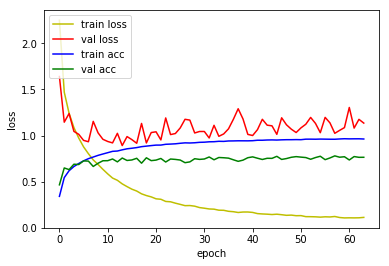

4815/4815 [==============================] - 4s 837us/sample - loss: 0.9833 - acc: 0.7188
Loss: 0.983314494131015 Accuracy: 0.7187954

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0785 - acc: 0.3723
Epoch 00001: val_loss improved from inf to 1.67620, saving model to model/checkpoint/1D_CNN_custom_DO_BN_5_conv_checkpoint/001-1.6762.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 2.0786 - acc: 0.3723 - val_loss: 1.6762 - val_acc: 0.4333
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3496 - acc: 0.5750
Epoch 00002: val_loss improved from 1.67620 to 1.18110, saving model to model/checkpoint/1D_CNN_custom_DO_BN_5_conv_checkpoint/002-1.1811.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.3497 - acc: 0.5749 - val_loss: 1.1811 - val_acc: 0.6219
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1207 - ac

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1160 - acc: 0.9624
Epoch 00057: val_loss did not improve from 0.66189
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1160 - acc: 0.9624 - val_loss: 0.8223 - val_acc: 0.8260
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1177 - acc: 0.9627
Epoch 00058: val_loss did not improve from 0.66189
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1177 - acc: 0.9627 - val_loss: 0.8716 - val_acc: 0.8118
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1219 - acc: 0.9604
Epoch 00059: val_loss did not improve from 0.66189
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1219 - acc: 0.9604 - val_loss: 0.7415 - val_acc: 0.8374
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1130 - acc: 0.9636
Epoch 00060: val_loss did not improve from 0.66189
36805/36805 [===========

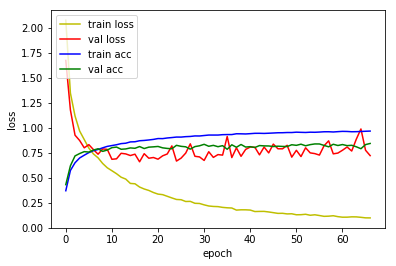

4815/4815 [==============================] - 4s 872us/sample - loss: 0.7455 - acc: 0.7836
Loss: 0.7454629350426536 Accuracy: 0.78359294

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1587 - acc: 0.3429
Epoch 00001: val_loss improved from inf to 1.46450, saving model to model/checkpoint/1D_CNN_custom_DO_BN_6_conv_checkpoint/001-1.4645.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 2.1587 - acc: 0.3429 - val_loss: 1.4645 - val_acc: 0.5483
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3337 - acc: 0.5802
Epoch 00002: val_loss improved from 1.46450 to 1.00688, saving model to model/checkpoint/1D_CNN_custom_DO_BN_6_conv_checkpoint/002-1.0069.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.3339 - acc: 0.5802 - val_loss: 1.0069 - val_acc: 0.6900
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0697 - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2674 - acc: 0.9188
Epoch 00025: val_loss improved from 0.39987 to 0.38563, saving model to model/checkpoint/1D_CNN_custom_DO_BN_6_conv_checkpoint/025-0.3856.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2674 - acc: 0.9188 - val_loss: 0.3856 - val_acc: 0.8963
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2622 - acc: 0.9192
Epoch 00026: val_loss did not improve from 0.38563
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2624 - acc: 0.9191 - val_loss: 0.4459 - val_acc: 0.8817
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2539 - acc: 0.9221
Epoch 00027: val_loss did not improve from 0.38563
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2539 - acc: 0.9221 - val_loss: 0.5135 - val_acc: 0.8609
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.23

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0744 - acc: 0.9764
Epoch 00083: val_loss did not improve from 0.34677
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0744 - acc: 0.9764 - val_loss: 0.4426 - val_acc: 0.9087
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0721 - acc: 0.9772
Epoch 00084: val_loss did not improve from 0.34677
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0723 - acc: 0.9771 - val_loss: 0.4679 - val_acc: 0.9005
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0817 - acc: 0.9743
Epoch 00085: val_loss did not improve from 0.34677
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0818 - acc: 0.9742 - val_loss: 0.5013 - val_acc: 0.8896
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0796 - acc: 0.9750
Epoch 00086: val_loss did not improve from 0.34677
36805/36805 [===========

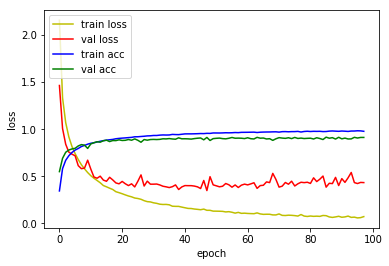

4815/4815 [==============================] - 4s 912us/sample - loss: 0.4158 - acc: 0.8831
Loss: 0.41578495934497284 Accuracy: 0.88307375

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3357 - acc: 0.2920
Epoch 00001: val_loss improved from inf to 1.55680, saving model to model/checkpoint/1D_CNN_custom_DO_BN_7_conv_checkpoint/001-1.5568.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 2.3356 - acc: 0.2921 - val_loss: 1.5568 - val_acc: 0.5106
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3698 - acc: 0.5600
Epoch 00002: val_loss improved from 1.55680 to 0.94665, saving model to model/checkpoint/1D_CNN_custom_DO_BN_7_conv_checkpoint/002-0.9467.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.3697 - acc: 0.5600 - val_loss: 0.9467 - val_acc: 0.7249
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0339 

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0737 - acc: 0.9763
Epoch 00054: val_loss did not improve from 0.19902
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0737 - acc: 0.9763 - val_loss: 0.2408 - val_acc: 0.9441
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0699 - acc: 0.9784
Epoch 00055: val_loss did not improve from 0.19902
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0701 - acc: 0.9783 - val_loss: 0.2620 - val_acc: 0.9352
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0776 - acc: 0.9747
Epoch 00056: val_loss did not improve from 0.19902
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0776 - acc: 0.9747 - val_loss: 0.2092 - val_acc: 0.9511
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0688 - acc: 0.9782
Epoch 00057: val_loss did not improve from 0.19902
36805/36805 [===========


1D_CNN_custom_DO_BN_7_conv Model


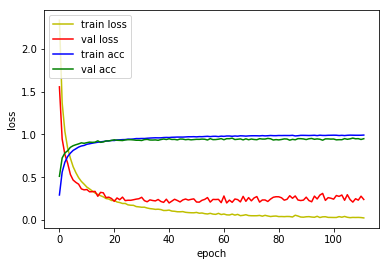

4815/4815 [==============================] - 5s 979us/sample - loss: 0.2449 - acc: 0.9304
Loss: 0.24487037120207075 Accuracy: 0.93042576

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2699 - acc: 0.3200
Epoch 00001: val_loss improved from inf to 1.48008, saving model to model/checkpoint/1D_CNN_custom_DO_BN_8_conv_checkpoint/001-1.4801.hdf5
36805/36805 [==============================] - 105s 3ms/sample - loss: 2.2698 - acc: 0.3201 - val_loss: 1.4801 - val_acc: 0.5525
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2113 - acc: 0.6161
Epoch 00002: val_loss improved from 1.48008 to 0.66948, saving model to model/checkpoint/1D_CNN_custom_DO_BN_8_conv_checkpoint/002-0.6695.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.2113 - acc: 0.6161 - val_loss: 0.6695 - val_acc: 0.8134
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8480 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1006 - acc: 0.9676
Epoch 00026: val_loss did not improve from 0.14149
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1006 - acc: 0.9676 - val_loss: 0.1490 - val_acc: 0.9590
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0969 - acc: 0.9692
Epoch 00027: val_loss did not improve from 0.14149
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0969 - acc: 0.9692 - val_loss: 0.1441 - val_acc: 0.9599
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0901 - acc: 0.9721
Epoch 00028: val_loss did not improve from 0.14149
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0902 - acc: 0.9720 - val_loss: 0.2033 - val_acc: 0.9406
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0970 - acc: 0.9680
Epoch 00029: val_loss did not improve from 0.14149
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9905
Epoch 00055: val_loss did not improve from 0.13313
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0316 - acc: 0.9905 - val_loss: 0.1481 - val_acc: 0.9630
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9901
Epoch 00056: val_loss did not improve from 0.13313
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0310 - acc: 0.9901 - val_loss: 0.2149 - val_acc: 0.9502
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9904
Epoch 00057: val_loss did not improve from 0.13313
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0314 - acc: 0.9904 - val_loss: 0.1750 - val_acc: 0.9595
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0482 - acc: 0.9843
Epoch 00058: val_loss improved from 0.13313 to 0.13158, saving model to model/checkpoint

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0149 - acc: 0.9957
Epoch 00085: val_loss did not improve from 0.13158
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0150 - acc: 0.9957 - val_loss: 0.1810 - val_acc: 0.9620
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9931
Epoch 00086: val_loss did not improve from 0.13158
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0220 - acc: 0.9931 - val_loss: 0.1921 - val_acc: 0.9595
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0183 - acc: 0.9946
Epoch 00087: val_loss did not improve from 0.13158
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0183 - acc: 0.9946 - val_loss: 0.2062 - val_acc: 0.9550
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9934
Epoch 00088: val_loss did not improve from 0.13158
36805/36805 [===========

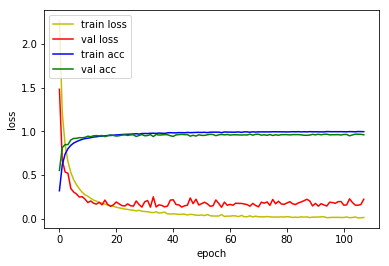

4815/4815 [==============================] - 5s 986us/sample - loss: 0.1814 - acc: 0.9479
Loss: 0.1813921118083556 Accuracy: 0.9478712

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8341 - acc: 0.4573
Epoch 00001: val_loss improved from inf to 0.89645, saving model to model/checkpoint/1D_CNN_custom_DO_BN_9_conv_checkpoint/001-0.8965.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 1.8339 - acc: 0.4573 - val_loss: 0.8965 - val_acc: 0.7508
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7684 - acc: 0.7600
Epoch 00002: val_loss improved from 0.89645 to 0.58270, saving model to model/checkpoint/1D_CNN_custom_DO_BN_9_conv_checkpoint/002-0.5827.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.7685 - acc: 0.7600 - val_loss: 0.5827 - val_acc: 0.8185
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5246 - 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9853
Epoch 00027: val_loss did not improve from 0.11981
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0473 - acc: 0.9853 - val_loss: 0.1522 - val_acc: 0.9555
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9872
Epoch 00028: val_loss did not improve from 0.11981
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0425 - acc: 0.9872 - val_loss: 0.1389 - val_acc: 0.9639
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9875
Epoch 00029: val_loss did not improve from 0.11981
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0415 - acc: 0.9875 - val_loss: 0.1412 - val_acc: 0.9630
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9867
Epoch 00030: val_loss did not improve from 0.11981
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9961
Epoch 00057: val_loss did not improve from 0.11981
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0135 - acc: 0.9961 - val_loss: 0.1628 - val_acc: 0.9623
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9951
Epoch 00058: val_loss did not improve from 0.11981
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0155 - acc: 0.9951 - val_loss: 0.1742 - val_acc: 0.9609
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0128 - acc: 0.9960
Epoch 00059: val_loss did not improve from 0.11981
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0129 - acc: 0.9960 - val_loss: 0.1680 - val_acc: 0.9655
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9925
Epoch 00060: val_loss did not improve from 0.11981
36805/36805 [===========

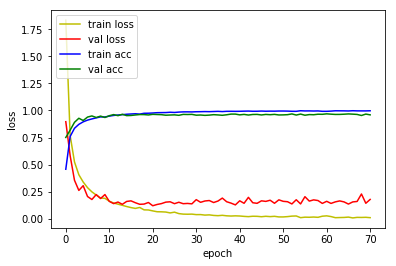

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1748 - acc: 0.9466
Loss: 0.17480578318215048 Accuracy: 0.9466251



In [9]:
base = '1D_CNN_custom_DO_BN'

for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [10]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
____________________________

4815/4815 [==============================] - 5s 995us/sample - loss: 0.9833 - acc: 0.7188
Loss: 0.983314494131015 Accuracy: 0.7187954

1D_CNN_custom_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 1600

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2449 - acc: 0.9304
Loss: 0.24487037120207075 Accuracy: 0.93042576

1D_CNN_custom_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 160

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1748 - acc: 0.9466
Loss: 0.17480578318215048 Accuracy: 0.9466251


In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
____________________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.2914 - acc: 0.7333
Loss: 1.2914326360292523 Accuracy: 0.73333335

1D_CNN_custom_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 1600

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2894 - acc: 0.9302
Loss: 0.28940941195621667 Accuracy: 0.93021804

1D_CNN_custom_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 160

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2345 - acc: 0.9470
Loss: 0.23451349686827366 Accuracy: 0.9470405
